# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline





### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
azdias.dtypes

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
          

In [9]:
feat_info.shape

(85, 4)

In [10]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [11]:
feat_info.dtypes

attribute             object
information_level     object
type                  object
missing_or_unknown    object
dtype: object

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.

In [13]:
# format missing_or_unknown to a list w/appropriate var types 

for x in range(0, len(feat_info['missing_or_unknown'])): 
    if "X" in feat_info['missing_or_unknown'][x]: 
        feat_info['missing_or_unknown'][x] = feat_info['missing_or_unknown'][x].strip(']')
        feat_info['missing_or_unknown'][x] = feat_info['missing_or_unknown'][x].strip('[')
        feat_info['missing_or_unknown'][x] = feat_info['missing_or_unknown'][x].split(',')
        
        for i in range(0, len(feat_info['missing_or_unknown'][x])):
            if "X" not in feat_info['missing_or_unknown'][x][i]:
                feat_info['missing_or_unknown'][x][i] = int(feat_info['missing_or_unknown'][x][i])
            else: 
                continue
    else: 
        try:
            feat_info['missing_or_unknown'][x] = ast.literal_eval(feat_info['missing_or_unknown'][x])
        except:
            print("something else occurred")


In [14]:
# sanity check 
print(type(feat_info['missing_or_unknown'][57]))
print(feat_info['missing_or_unknown'][57])

<class 'list'>
[-1, 'X']


In [15]:
# check amount of originally encoded nans
# save original counts and series for potential analysis later 
original_nan_count = azdias.isnull().sum().sum()
original_nan_series = azdias.isnull().sum()

In [16]:
# replace missing_or_unknown values w/nans 

for i in range(0, len(feat_info)): 
    attribute = feat_info.iloc[i]['attribute']
    nan_values = feat_info.iloc[i]['missing_or_unknown']
    for v in nan_values:
        azdias[attribute] = azdias[attribute].replace(v, np.nan)


In [17]:
# save amount of nans after coding missing_or_unknown as a count and series
actual_nan_count = azdias.isnull().sum().sum()
actual_nan_series = azdias.isnull().sum()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
print('azdias data has {} original NaN and {} actual NaNs after coding missing_or_unknown values'.format(original_nan_count, actual_nan_count))


azdias data has 4896838 original NaN and 8373929 actual NaNs after coding missing_or_unknown values


count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64


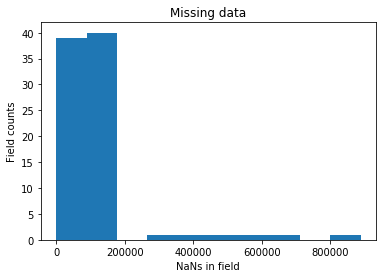

In [19]:
print(actual_nan_series.describe()) 
perc_cutoff = actual_nan_series.describe()['75%']
plt.hist(actual_nan_series)
plt.ylabel('Field counts')
plt.xlabel('NaNs in field')
plt.title('Missing data')
plt.show()

In [20]:
# Investigate patterns in the amount of missing data in each column.
# actual_nan_series.plot(kind='barh', title='Actual NaN counts', figsize = (8,23))

In [21]:
# view actual amount of missing values for each field
# actual_nan_series.sort_values(ascending=False)


In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# create list of cols to keep 
keep_cols = []

for i,v in actual_nan_series.iteritems():     
    if v < perc_cutoff:
        keep_cols.append(i)
    else: 
        continue

# create list of remove cols for discussion
remove_cols = []

for i,v in actual_nan_series.iteritems():     
    if v >= perc_cutoff:
        remove_cols.append(i)
    else: 
        continue
        
        
print("{} columns to keep from azdias data".format(len(keep_cols)))


63 columns to keep from azdias data


In [23]:
# remove cols from df 
azdias_clean_cols = azdias[keep_cols]


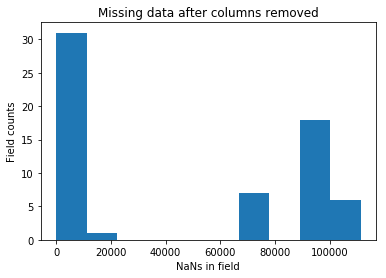

In [24]:
# new missing data distribution
clean_cols_nan_series = azdias_clean_cols.isnull().sum()
plt.hist(clean_cols_nan_series)
plt.ylabel('Field counts')
plt.xlabel('NaNs in field')
plt.title('Missing data after columns removed')
plt.show()

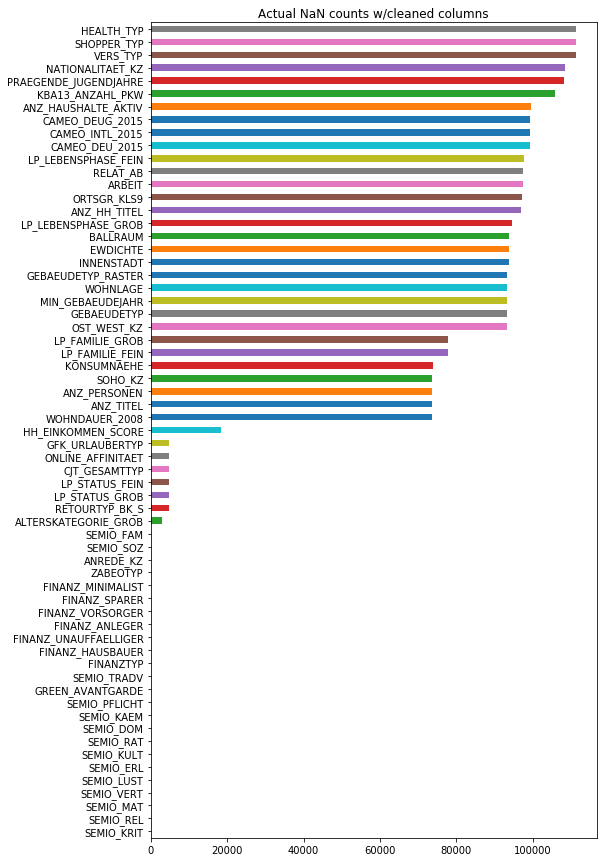

In [25]:
clean_cols_nan_series.sort_values().plot(kind='barh', title='Actual NaN counts w/cleaned columns', figsize = (8,15))

In [26]:
azdias_removed_cols = azdias[remove_cols]
removed_series = azdias_removed_cols.isnull().sum()
print("summary of removed columns\n\n", removed_series)

# print("\n\n summary of remaining columns \n\n", clean_cols_nan_series.sort_values(ascending=False))  

summary of removed columns

 AGER_TYP          685843
GEBURTSJAHR       392318
TITEL_KZ          889061
ALTER_HH          310267
KK_KUNDENTYP      584612
W_KEIT_KIND_HH    147988
KBA05_ANTG1       133324
KBA05_ANTG2       133324
KBA05_ANTG3       133324
KBA05_ANTG4       133324
KBA05_BAUMAX      476524
KBA05_GBZ         133324
KKK               158064
MOBI_REGIO        133324
REGIOTYP          158064
PLZ8_ANTG1        116515
PLZ8_ANTG2        116515
PLZ8_ANTG3        116515
PLZ8_ANTG4        116515
PLZ8_BAUMAX       116515
PLZ8_HHZ          116515
PLZ8_GBZ          116515
dtype: int64


#### Discussion 1.1.2: Assess Missing Data in Each Column


I identified outliers as anything at or over the 75th percentile (i.e. >= 116515 missing values). So, if a field has >= 13% (116515/len(azdias)) of missing data, then I dropped the field. Columns removed and missing data for those columns are summarized in the cell above. For the remaining 63 fields kept, a fair amount have 0-10k NaNs, while some fields have 90k-11k NaNs. Again, note that all remaining fields have at lease ~87% of data. 

For the remaining columns, these seem to be a few preliminary patterns. the Semio fields do not appear to have missing data, while other fields like the Cameo fields have a similar amount of missing data. With trends like these, I'd hypothesize taht similarly named variables with similar missing data patterns might lend themselves to latent variables to reduce the dimensionality of this dataset. 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Missing data in rows summary 
 count    891221.000000
mean          6.079626
std           5.928445
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          22.000000
dtype: float64


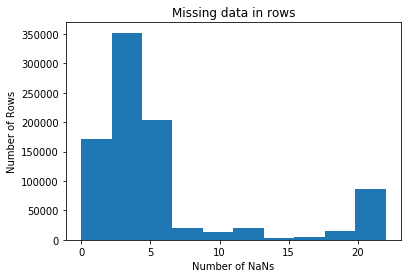

In [27]:
# How much data is missing in each row of the dataset?
row_nan_series = azdias_removed_cols.isnull().sum(axis=1)
row_cutoff = row_nan_series.describe()['75%']

print("Missing data in rows summary \n", row_nan_series.describe())
plt.hist(row_nan_series)
plt.ylabel('Number of Rows')
plt.xlabel('Number of NaNs')
plt.title('Missing data in rows')
plt.show()

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_clean_cols_1 = azdias_clean_cols[azdias_clean_cols.isnull().sum(axis=1) <= row_cutoff]
azdias_clean_cols_2 = azdias_clean_cols[azdias_clean_cols.isnull().sum(axis=1) > row_cutoff]

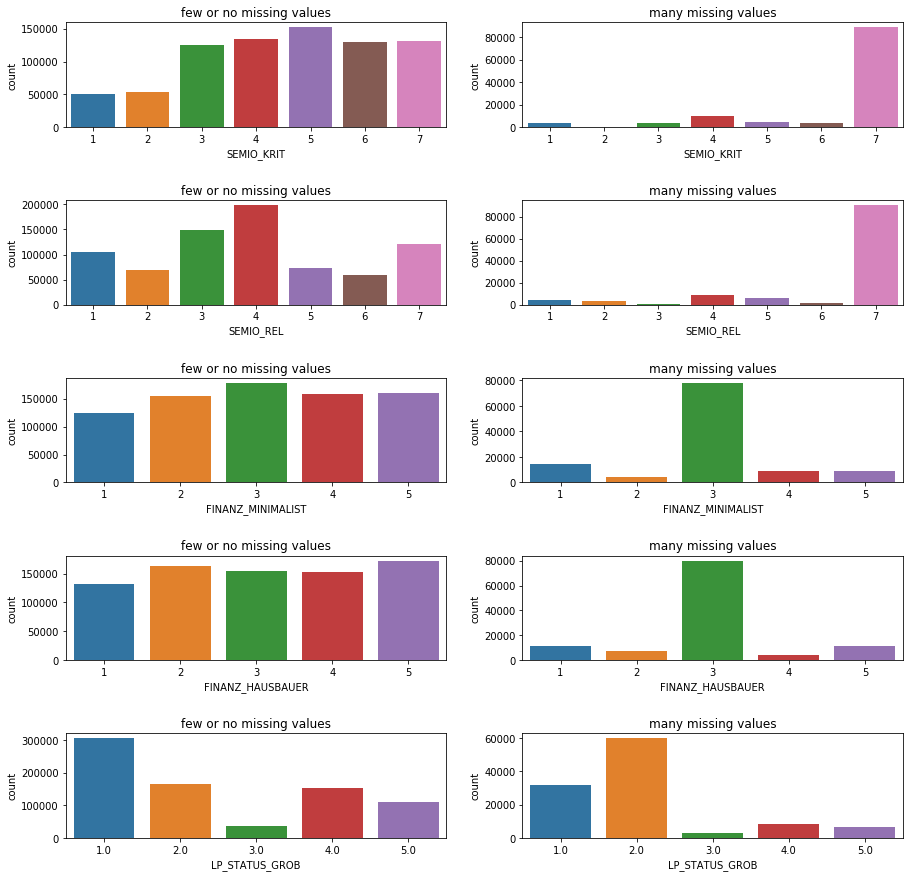

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


# used below to select 5 columns w/no or few missing values 
# clean_cols_nan_series.sort_values()

dist_cols = ['SEMIO_KRIT', 'SEMIO_REL', 'FINANZ_MINIMALIST', 
             'FINANZ_HAUSBAUER', 'LP_STATUS_GROB']

figure, axs = plt.subplots(nrows=len(dist_cols), ncols=2, figsize = (15, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(len(dist_cols)):
    sns.countplot(data=azdias_clean_cols_1, x=dist_cols[i], ax=axs[i][0])
    axs[i][0].set_title('few or no missing values')
    sns.countplot(data=azdias_clean_cols_2, x=dist_cols[i], ax=axs[i][1])
    axs[i][1].set_title('many missing values')


#### Discussion 1.1.3: Assess Missing Data in Each Row

The distributions for the data with few or no missing values and many missing values are quite different for the variables I examined. SEMIO_KRIT and SEMIO_REL have smilar distributions in that the subsets with many missing values have large amounts of 7s, while the subsets with few or no missing values have a fair amount of observations for each value (1-7). Similarly, the FINANZ_MINIMALIST and FINANZ_HAUSBAUER subsets with many missing values have large amounts of 3s, while the subsets with few or no missing values have a fair amount of observations for each value (1-5). LP_STATUS_GROB does not follow a similar pattern and the two subsets do not have as striking a difference in distribution. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?
clean_cols = list(azdias_clean_cols_1)
feat_info_clean = feat_info[feat_info['attribute'].isin(clean_cols)]

print("data types and counts")
feat_info_clean['type'].value_counts()

data types and counts


ordinal        34
categorical    18
numeric         6
mixed           5
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_cols = feat_info_clean[feat_info_clean['type']=='categorical']['attribute'].unique().tolist()
binary_features = []
multi_level_features = []

for col in cat_cols:
    col_values = azdias_clean_cols_1[col].unique()
    values = []
    
    for v in col_values:
        values.append(v)

    if len(values) == 2:
        binary_features.append(col)
    
    elif len(values) > 2: 
        multi_level_features.append(col)
    
    else:
        print("what's up with values in {}?".format(col))


In [32]:
# binary features and values
print("binary features and values include: ")
for f in binary_features:
    print("variable: ", f)
    print("values: ",azdias_clean_cols_1[f].unique())


binary features and values include: 
variable:  ANREDE_KZ
values:  [2 1]
variable:  GREEN_AVANTGARDE
values:  [0 1]
variable:  SOHO_KZ
values:  [ 1.  0.]
variable:  OST_WEST_KZ
values:  ['W' 'O']


In [33]:
# multilevel features and values
print("multi-level features and values include: ")
for f in multi_level_features:
    print(f)
    print("values: ",azdias_clean_cols_1[f].unique())


multi-level features and values include: 
CJT_GESAMTTYP
values:  [ 5.  3.  2.  4.  1.  6.]
FINANZTYP
values:  [1 6 5 2 4 3]
GFK_URLAUBERTYP
values:  [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.]
LP_FAMILIE_FEIN
values:  [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB
values:  [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN
values:  [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.]
LP_STATUS_GROB
values:  [ 1.  2.  4.  5.  3.]
NATIONALITAET_KZ
values:  [  1.   3.   2.  nan]
SHOPPER_TYP
values:  [  3.   2.   1.   0.  nan]
VERS_TYP
values:  [  2.   1.  nan]
ZABEOTYP
values:  [5 3 4 1 6 2]
GEBAEUDETYP
values:  [ 8.  1.  3.  2.  6.  4.  5.]
CAMEO_DEUG_2015
values:  ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015
values:  ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.

# drop multilevel variables
azdias_clean = azdias_clean_cols_1.drop(labels=multi_level_features, axis=1)
print("dropped {} multi level columns".format(len(multi_level_features)))

# re-encode binary non-numeric variable 
azdias_clean = azdias_clean.replace({'OST_WEST_KZ':{'W': 0, 'O': 1}})
print("re-encoded binary non-numeric column")

print("proceeding with {} columns".format(len(list(azdias_clean))))

dropped 14 multi level columns
re-encoded binary non-numeric column
proceeding with 49 columns


48

#### Discussion 1.2.1: Re-Encode Categorical Features

I found four binary features, one of which was non numeric. For this variable (OST_WEST_KZ), I encoded 'W' as 0 and 'O' as 1. I also found 14 multi-level features with more than 2 unique values for each fature. For simplicity, I dropped these columns. We'll proceed with 43 non multi-level features. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# view mixed features. Note, not all of these are currently in the dataset we're cleaning. 
    # Some may have already been dropped
mixed_features = feat_info[feat_info['type']=='mixed']
print(mixed_features)

                attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed            [-1, 0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed           [-1, XX]
64           KBA05_BAUMAX     microcell_rr3  mixed            [-1, 0]
79            PLZ8_BAUMAX    macrocell_plz8  mixed            [-1, 0]


In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# 1.18. PRAEGENDE_JUGENDJAHRE
# interval type for decade and binary for movement 

# decade - 40s = 1, 50s = 2, 60s = 3, 70 = 4, 80s = 5, 90s = 6
decade_mapping = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 
                  7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5,
                 13: 5, 14: 6, 15: 6}

# mainstream = 0, avantgarde = 1
movement_mapping = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 
                    9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1}

azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].replace(decade_mapping)
azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].replace(movement_mapping)


In [37]:
print("unique decade values: ", azdias_clean['DECADE'].unique()) 
print("unique movement values: ",azdias_clean['MOVEMENT'].unique()) 


unique decade values:  [  6.   4.   2.   5.   3.  nan   1.]
unique movement values:  [  0.   1.  nan]


In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# create wealth and life stage 
### 4.3. CAMEO_INTL_2015 in data_dictionary 

# Poorer Households = 1, Less Affluent Households = 2, Comfortable Households = 3
# Prosperous Households = 4, Wealthy Households = 5
def wealth_mapping(x):
    if x in ('51', '52', '53', '54', '55'): 
        return 1
    if x in ('41', '42', '43', '44', '45'):
        return 2
    if x in ('31', '32', '33', '34', '35'):
        return 3
    if x in ('21', '22', '23', '24', '25'):
        return 4
    if x in ('11', '12', '13', '14', '15'):
        return 5

# Pre-Family Couples & Singles = 1, Young Couples With Children = 2, 
# Families With School Age Children = 3, Older Families &  Mature Couples = 4
# Elders In Retirement = 5
def life_stage_mapping(x):
    if x in ('11', '21', '31', '41', '51'):
        return 1
    if x in ('12', '22', '32', '42', '52'):
        return 2
    if x in ('13', '23', '33', '43', '53'):
        return 3
    if x in ('14', '24', '34', '44', '54'):
        return 4
    if x in ('15', '25', '35', '45', '55'):
        return 5

azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015'].apply(wealth_mapping)
azdias_clean['LIFE_STAGE'] = azdias_clean['CAMEO_INTL_2015'].apply(life_stage_mapping)


In [39]:
print("unique wealth values: ", azdias_clean['WEALTH'].unique())
print("unique life stage values: ", azdias_clean['LIFE_STAGE'].unique())


unique wealth values:  [  1.   4.   5.   2.   3.  nan]
unique life stage values:  [  1.   4.   2.   3.   5.  nan]


In [40]:
# DROP OTHER MIXED VARIABLES 
mixed_features_to_drop = mixed_features['attribute'].values.tolist()
print("dataset currently has {} columns".format(len(list(azdias_clean))))

features_dropped = []

for f in mixed_features_to_drop:
    if f in list(azdias_clean):
        azdias_clean.drop(f, axis=1, inplace=True)
        features_dropped.append(f)
    else:
        continue
        
print("dropped {} columns from the dataset".format(len(features_dropped)))
print("proceeding with {} columns in dataset".format(len(list(azdias_clean))))

dataset currently has 53 columns
dropped 5 columns from the dataset
proceeding with 48 columns in dataset


In [154]:
# len(azdias_clean.columns)

#### Discussion 1.2.2: Engineer Mixed-Type Features

To practice, I coded the variables differently. For PRAEGENDE_JUGENDJAHRE, I use the replace method with a dictionary mapping and for CAMEO_INTL_2015, I created a couple functions and used the apply method. 

Before this step, we had 49 columns. We created 4 new columns by feature engineering PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, then dropped 5 columns. So, we'll be proceeding with 48 columns. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# 
# feat_info for cols kept
feat_info_clean = feat_info[feat_info['attribute'].isin(list(azdias_clean))]
print("unique variable types remaining: ",feat_info_clean['type'].unique())

# check that categorical variables are binary 
    # list of variables to potentially one hot encode 
categorical_cols = feat_info_clean[feat_info_clean['type'] == 'categorical']['attribute'].tolist()

for col in categorical_cols:
    print("\n{} has {} values".format(col, len(azdias_clean[col].unique())))
    print("values are ", azdias_clean[col].unique())
        
# variables re-engineered and not in feat_info
# DECADE (ordinal), MOVEMENT (binary), WEALTH (ordinal), LIFE_STAGE (ordinal)

unique variable types remaining:  ['ordinal' 'categorical' 'numeric']

ANREDE_KZ has 2 values
values are  [2 1]

GREEN_AVANTGARDE has 2 values
values are  [0 1]

SOHO_KZ has 2 values
values are  [ 1.  0.]

OST_WEST_KZ has 2 values
values are  [0 1]


In [42]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

print("data appears to be appropriately formatted")


data appears to be appropriately formatted


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # summarize input df
    print("df has {} rows and {} columns".format(len(df), len(list(df))))

    ##### Step 1) convert missing value codes into NaNs ##### 
    print("\n#### step 1) converting missing values codes into NaNs")
    
    # feat_info['missing_or_unknown'] already defined in notebook 

    # check amount of originally encoded nans
    # save original counts and series for potential analysis later 
    original_nan_count = df.isnull().sum().sum()

    # replace missing_or_unknown values w/nans 
    for i in range(0, len(feat_info)): 
        attribute = feat_info.iloc[i]['attribute']
        nan_values = feat_info.iloc[i]['missing_or_unknown']
        for v in nan_values:
            df[attribute] = df[attribute].replace(v, np.nan)

    # save amount of nans after coding missing_or_unknown as a count and series
    actual_nan_count = df.isnull().sum().sum()

    # print summary of NaNs encoded 
    print("\nfinished encoding NaNs")
    print('\nData has {} original NaN and {} actual NaNs after coding missing_or_unknown values'.format(original_nan_count, actual_nan_count))


    ##### Step 2) remove selected columns and rows ##### 
    print("\n#### step 2) removing selected columns and rows")
    
    # keep same cols as azdias 
        # using a percentile cutoff might produce different results 
    df_clean_cols = azdias[keep_cols]

    # row cutoff can be a percentile
    row_nan_series = df_clean_cols.isnull().sum(axis=1)
    row_cutoff = row_nan_series.describe()['75%']

    # create subset with at least 75% of row values filled
    df_clean_col_rows = df_clean_cols[df_clean_cols.isnull().sum(axis=1) <= row_cutoff]
    print("\nfinished removing selected columns and rows")


    ##### Step 3) select, re-encode, and engineer column values ##### 
    print("\n#### step 3) selecting, re-encoding, and engineering columns")
    
    # Re-encode categorical variable(s) to be kept in the analysis.

    # drop multilevel variables
    # multi_level_features already defined in notebook
    df_clean = df_clean_col_rows.drop(labels=multi_level_features, axis=1)
    print("\ndropped {} multi level columns".format(len(multi_level_features)))

    # re-encode binary non-numeric variable 
    df_clean = df_clean.replace({'OST_WEST_KZ':{'W': 0, 'O': 1}})
    print("\nre-encoded binary non-numeric column")

    print("\nproceeding with {} columns".format(len(list(df_clean))))

    # engineer two new variables from "PRAEGENDE_JUGENDJAHRE"
    # mapping already defined in notebook 
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].replace(decade_mapping)
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE'].replace(movement_mapping)

    # engineer two new variables for "CAMEO_INTL_2015"
    # mapping already defined in notebook 
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015'].apply(wealth_mapping)
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015'].apply(life_stage_mapping)

    # DROP OTHER MIXED VARIABLES 
    # mixed_features_to_drop = mixed_features['attribute'].values.tolist()
        # already defined in notebook
    print("\ndataset currently has {} columns".format(len(list(df_clean))))

    features_dropped = []

    for f in mixed_features_to_drop:
        if f in list(df_clean):
            df_clean.drop(f, axis=1, inplace=True)
            features_dropped.append(f)
        else:
            continue
            
    print("\ndropped {} columns from the dataset".format(len(features_dropped)))

    print("\nfinal df contains")
    print("{} columns and {} rows".format(len(list(df_clean)), len(df_clean)))
     
    
    # Return the cleaned dataframe.
    return df_clean
    


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
# If you've not yet cleaned the dataset of all NaN values, 
# then investigate and do that now.
imp = Imputer(strategy='most_frequent')
azdias_clean_imp = pd.DataFrame(imp.fit_transform(azdias_clean))

# apply same cols and index to imp data 
azdias_clean_imp.columns = azdias_clean.columns
azdias_clean_imp.index = azdias_clean.index


In [45]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
azdias_clean_imp_scaled = scaler.fit_transform(azdias_clean_imp)

# convert np array to dataframe
azdias_clean_imp_scaled = pd.DataFrame(azdias_clean_imp_scaled, columns=list(azdias_clean_imp))


In [141]:

# azdias_clean_imp_scaled.isnull().sum()

### Discussion 2.1: Apply Feature Scaling

I imputed missing values with most frequent values. This may overrepresent the most frequent value for variables with missing data, but I believe the bias that imputing most frequent introduces is less than the bias that would result in dropping observations with any missing data completely. 

I also used the StandardScaler to scale each feature ot a mean of 0 and standard deviation of 1. 


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [47]:
# Apply PCA to the data.
    # do not set n_components 
pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(azdias_clean_imp_scaled))

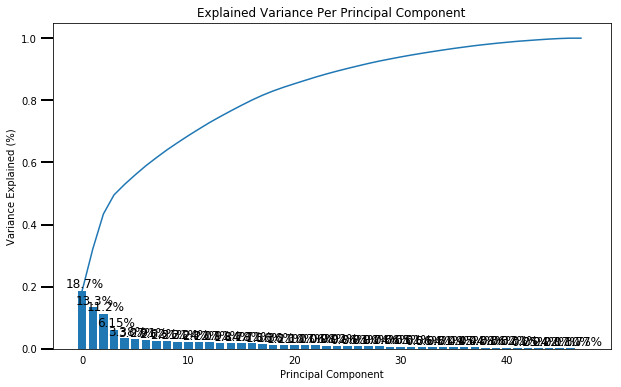

In [48]:
# Investigate the variance accounted for by each principal component.

#function taken from interpret pca results lesson 
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [49]:
expl_var = pca.explained_variance_ratio_.tolist()
cum_expl_var = np.cumsum(pca.explained_variance_ratio_).tolist()
expl_var_sum = zip(expl_var, cum_expl_var)
pc = 0
for a, b in expl_var_sum:
    expl_var = round(a*100, 1)
    cum_expl_var = round(b*100, 1)
    print("pc:", pc, "var expl:", expl_var, 
          "cum var expl:", cum_expl_var)
    pc += 1 


pc: 0 var expl: 18.8 cum var expl: 18.8
pc: 1 var expl: 13.4 cum var expl: 32.1
pc: 2 var expl: 11.3 cum var expl: 43.4
pc: 3 var expl: 6.2 cum var expl: 49.6
pc: 4 var expl: 3.4 cum var expl: 52.9
pc: 5 var expl: 3.1 cum var expl: 56.0
pc: 6 var expl: 2.9 cum var expl: 58.9
pc: 7 var expl: 2.6 cum var expl: 61.6
pc: 8 var expl: 2.5 cum var expl: 64.1
pc: 9 var expl: 2.3 cum var expl: 66.4
pc: 10 var expl: 2.2 cum var expl: 68.6
pc: 11 var expl: 2.1 cum var expl: 70.7
pc: 12 var expl: 2.1 cum var expl: 72.8
pc: 13 var expl: 1.9 cum var expl: 74.7
pc: 14 var expl: 1.8 cum var expl: 76.6
pc: 15 var expl: 1.8 cum var expl: 78.4
pc: 16 var expl: 1.7 cum var expl: 80.1
pc: 17 var expl: 1.6 cum var expl: 81.6
pc: 18 var expl: 1.4 cum var expl: 83.0
pc: 19 var expl: 1.2 cum var expl: 84.2
pc: 20 var expl: 1.1 cum var expl: 85.3
pc: 21 var expl: 1.1 cum var expl: 86.4
pc: 22 var expl: 1.1 cum var expl: 87.5
pc: 23 var expl: 1.0 cum var expl: 88.5
pc: 24 var expl: 0.9 cum var expl: 89.4
pc: 25 

In [50]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(24)
azdias_pca = pd.DataFrame(pca.fit_transform(azdias_clean_imp_scaled))


### Discussion 2.2: Perform Dimensionality Reduction

I used 24 components because it's half the columns available in my cleaned dataset and 24 principal components explain almost 90% (89.4%) of the variance in the data. 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [63]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def print_pc_weights(pc, data):
    # get df of pca components weight
    df = pd.DataFrame(pca.components_[pc])
    # map index to col names 
    df.index = data.columns
    # name col
    df.columns = ['PC']
    df['PC_abs'] = df['PC'].abs()
    # sort values for readability 
    df.sort_values(by=['PC_abs'], ascending=False, inplace=True)
    return df

pc1 = print_pc_weights(0, azdias_clean_imp_scaled)
print(pc1[:10])

                             PC    PC_abs
ALTERSKATEGORIE_GROB  -0.288157  0.288157
FINANZ_SPARER          0.282184  0.282184
SEMIO_REL              0.278561  0.278561
DECADE                 0.261072  0.261072
FINANZ_VORSORGER      -0.259008  0.259008
SEMIO_PFLICHT          0.258029  0.258029
SEMIO_TRADV            0.247926  0.247926
SEMIO_ERL             -0.238013  0.238013
FINANZ_UNAUFFAELLIGER  0.233041  0.233041
SEMIO_KULT             0.222143  0.222143


In [64]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2 = print_pc_weights(1, azdias_clean_imp_scaled)
print(pc2[:10])


                         PC    PC_abs
SEMIO_KAEM         0.323513  0.323513
ANREDE_KZ          0.315470  0.315470
SEMIO_VERT        -0.313902  0.313902
SEMIO_DOM          0.281368  0.281368
SEMIO_KRIT         0.253398  0.253398
FINANZ_MINIMALIST -0.240866  0.240866
SEMIO_KULT        -0.211521  0.211521
SEMIO_FAM         -0.207769  0.207769
SEMIO_SOZ         -0.204332  0.204332
FINANZ_HAUSBAUER   0.192825  0.192825


In [65]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc3 = print_pc_weights(2, azdias_clean_imp_scaled)
print(pc3[:10])


                          PC    PC_abs
ORTSGR_KLS9         0.278622  0.278622
EWDICHTE            0.273713  0.273713
INNENSTADT         -0.238763  0.238763
WEALTH             -0.237514  0.237514
KONSUMNAEHE        -0.217868  0.217868
ARBEIT              0.215661  0.215661
HH_EINKOMMEN_SCORE  0.202446  0.202446
ANREDE_KZ          -0.201095  0.201095
RELAT_AB            0.200663  0.200663
BALLRAUM           -0.193923  0.193923


### Discussion 2.3: Interpret Principal Components

Principal component 1 appears to be an indicator for age and some asosciated financial and peronality traits. Though some relationships are counterintuitive, for the most part, it seems as though higher values for the first principal component indicate that, in general, the person is younger (ALTERSKATEGORIE_GROB, DECADE), less of a money saver (FINANZ_SPARER), less traditional and cultural minded (SEMIO_TRADV, SEMIO_KULT). At the same time, higher values for this principal component indicate that, in general, the person is more financially prepared (FINANZ_VORSORGER) and more religious (SEMIO_REL). Perhaps this latent feature will help us identify customer segments that may be more likely to spend/engage. 

Principal component 2 appears to be an indicator for free spiritness. Those who have higher values for this principal component tend to be less combative (SEMIO_KAEM), more dreamful (SEMIO_VERT), less dominant minded (SEMIO_DOM), less critical minded (SEMIO_KRIT), more cultural minded (SEMIO_KULT), more family minded (SEMIO_FAM), and more socially minded (SEMIO_SOZ). On the financial dimension, these people tend to have lower financial interest (FINANZ_MINIMALIST), potentially not valuing money and goods that money can afford, and lower home ownership (FINANZ_HAUSBAUER). 

Principal component 3 appears to be a measure of the extent to which person is in an urban and poor area. People with higher levels of this principal component tend to live in areas that have a bigger community (ORTSGR_KLS9), denser area (EWDICHTE), closer to the city center (INNENSTADT), closer to the urban center (BALLRAUM). These people also tend to be poorer (WEALTH), have higher unemployment (ARBEIT, RELAT_AB), and lower income (HH_EINKOMMEN_SCORE).


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [54]:
from sklearn.cluster import KMeans

In [55]:
# Over a number of different cluster counts
# run k-means clustering on the data and 
# compute the average within-cluster distances.

# function taken from lesson 1 clustering - screencast: solution
def kmeans_score(n_clusters, data):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=n_clusters)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
for i in range(1, 11):
    s = kmeans_score(i, azdias_pca)
    scores.append(s)


Text(0,0.5,'SSE')

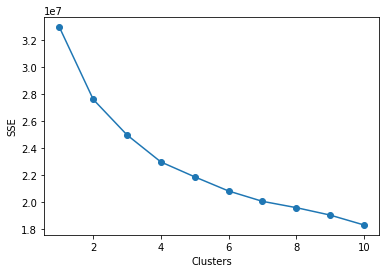

In [56]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# plot code taken from lesson 1 clustering - screencast: solution
plt.plot(range(1,11), scores, linestyle='-', marker='o')
plt.xlabel('Clusters')
plt.ylabel('SSE')


In [57]:
scores

[32966708.371311393,
 27624348.990325797,
 24990729.884869397,
 22993797.605674807,
 21890574.372153595,
 20843509.49678601,
 20078785.153657034,
 19611603.732183799,
 19062377.772714175,
 18330966.587964058]

In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=6)
k_means_model = kmeans.fit(azdias_pca)
azdias_pca_pred = model.predict(azdias_pca)



In [59]:
np.unique(azdias_pca_pred)

array([0, 1, 2, 3, 4, 5], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

I chose 6 clusters because this appears to be the elbow where increasing the number of clusters (k) no longer leads to significant decrease from center (i.e. the returns in SSE apear to be dimishing after this point)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [60]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


In [61]:
# preprocessing
customers_clean = clean_data(customers)

df has 191652 rows and 85 columns

#### step 1) converting missing values codes into NaNs

finished encoding NaNs

Data has 2252274 original NaN and 3112918 actual NaNs after coding missing_or_unknown values

#### step 2) removing selected columns and rows

finished removing selected columns and rows

#### step 3) selecting, re-encoding, and engineering columns

dropped 14 multi level columns

re-encoded binary non-numeric column

proceeding with 49 columns

dataset currently has 53 columns

dropped 5 columns from the dataset

final df contains
48 columns and 700781 rows


In [77]:
def feature_transformation_clustering(data):
    # functionize  step 2: Feature Transformation

    # apply feature scaling
    imp = Imputer(strategy='most_frequent')
    data_clean_imp = pd.DataFrame(imp.fit_transform(data))

    # apply same cols and index to imp data 
    data_clean_imp.columns = data.columns
    data_clean_imp.index = data.index

    # Apply feature scaling to the general population demographics data.
    scaler = StandardScaler() 
    data_clean_imp_scaled = scaler.fit_transform(data_clean_imp)

    # convert np array to dataframe
    data_clean_imp_scaled = pd.DataFrame(data_clean_imp_scaled, columns=list(data_clean_imp))

    print("applied feature scaling")

    # transform data using currently defined PCA object
    data_pca = pca.transform(data_clean_imp_scaled)
    data_pca = pd.DataFrame(data_pca)

    print("transformed data with currently defined pca object")

    # predict clustering using currently defined kmeans object
    cluster_predictions = k_means_model.predict(data_pca)

    print("predicted clusters with currently defined kmeans object")

    print("returning final dataframe and cluster predictions array")
    return data_pca, cluster_predictions



In [78]:
customers_pca, customer_cluster_preds = feature_transformation_clustering(customers_clean)



applied feature scaling
transformed data with currently defined pca object
predicted clusters with currently defined kmeans object
returning final dataframe and cluster predictions array


In [89]:
# customers_pca.head()
# np.unique(customer_cluster_preds)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Customer Data Clusters')

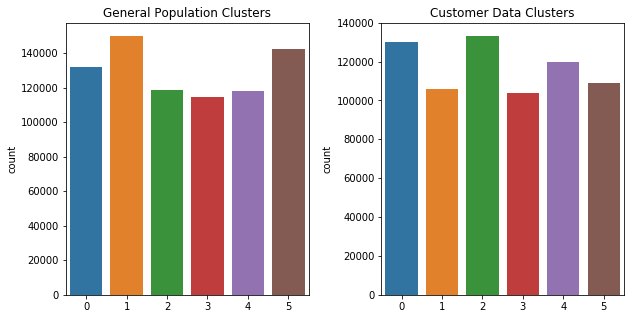

In [117]:
# Compare the proportion of data in each cluster for the 
# customer data to the proportion of data in each cluster 
# for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))
plt.subplots_adjust(wspace=0.3)
sns.countplot(azdias_pca_pred, ax=axs[0])
axs[0].set_title("General Population Clusters")
sns.countplot(customer_cluster_preds, ax=axs[1])
axs[1].set_title("Customer Data Clusters")


In [ ]:
# store medians for general population for comparision later
median = azdias_clean.describe()
median = avgs.loc['50%']

In [239]:
# What kinds of people are part of a cluster that is 
# overrepresented in the customer data compared to the 
# general population?

# cluster 2 is overrepresented in customer data 
# return centroid to original data space 

# array of cluster centers for each principal component 
overrep = k_means_model.cluster_centers_[2]

# inverse_transform() method of the PCA and StandardScaler objects
overrep = pca.inverse_transform(overrep)
overrep = scaler.inverse_transform(overrep)

# convert array to series 
overrep = pd.Series(data = overrep, index = azdias_clean.columns)

# create df w/general median values and compare
overrep_median = pd.concat([overrep, median], axis=1)
overrep_median.rename(columns={0:'overrep', '50%': 'general_median'}, 
                      inplace=True)
overrep_median['overrep_perc_diff'] = (overrep_median['overrep']-overrep_median['general_median'])/(overrep_median['general_median']+0.001)
overrep_median['overrep_perc_diff_abs'] = overrep_median['overrep_perc_diff'].abs()
overrep_median.sort_values(by=['overrep_perc_diff_abs'], ascending=False, inplace=True)
print(overrep_median[['overrep','general_median','overrep_perc_diff_abs']])


                           overrep  general_median  overrep_perc_diff_abs
OST_WEST_KZ               0.207990             0.0             207.990314
GREEN_AVANTGARDE          0.128809             0.0             128.808913
MOVEMENT                  0.128809             0.0             128.808913
ANZ_HH_TITEL              0.035213             0.0              35.213375
SOHO_KZ                   0.008290             0.0               8.290137
ANZ_TITEL                 0.001816             0.0               1.816136
ANZ_HAUSHALTE_AKTIV       8.457982             4.0               1.114217
FINANZ_SPARER             4.102946             2.0               1.050948
FINANZ_UNAUFFAELLIGER     3.777274             2.0               0.888193
ANZ_PERSONEN              1.714538             1.0               0.713824
SEMIO_RAT                 6.294261             4.0               0.573422
SEMIO_PFLICHT             6.200347             4.0               0.549949
SEMIO_VERT                2.370751    

In [237]:
# What kinds of people are part of a cluster that is 
# underrepresented in the customer data compared 
# to the general population?

# cluster 1 is underrep in customer data 
# return centroid to original data space 

# array of cluster centers for each principal component 
underrep = k_means_model.cluster_centers_[1]

# inverse_transform() method of the PCA and StandardScaler objects
underrep = pca.inverse_transform(underrep)
underrep = scaler.inverse_transform(underrep)

# convert array to series 
underrep = pd.Series(data = underrep, index = azdias_clean.columns)

# create series w/avg values for entire dataframe and compare against cluster 

# create df w/general median values and compare
underrep_median = pd.concat([underrep, median], axis=1)
underrep_median.rename(columns={0:'underrep', '50%': 'general_median'}, 
                      inplace=True)
underrep_median['underrep_perc_diff'] = (underrep_median['underrep']-underrep_median['general_median'])/(underrep_median['general_median']+0.001)
underrep_median['underrep_diff_perc_abs'] = underrep_median['underrep_perc_diff'].abs()
underrep_median.sort_values(by=['underrep_diff_perc_abs'], ascending=False, inplace=True)
print(underrep_median[['underrep','general_median','underrep_diff_perc_abs']])


                          underrep  general_median  underrep_diff_perc_abs
OST_WEST_KZ               0.279500             0.0              279.500319
ANZ_HH_TITEL              0.088074             0.0               88.074456
GREEN_AVANTGARDE          0.084808             0.0               84.808022
MOVEMENT                  0.084808             0.0               84.808022
SOHO_KZ                   0.007539             0.0                7.538907
ANZ_TITEL                 0.003712             0.0                3.712302
ANZ_HAUSHALTE_AKTIV      14.515690             4.0                2.628265
SEMIO_ERL                 6.554291             4.0                0.638413
SEMIO_KAEM                6.141986             4.0                0.535363
SEMIO_KULT                1.886979             4.0                0.528123
SEMIO_REL                 2.045273             4.0                0.488560
SEMIO_FAM                 2.168113             4.0                0.457857
SEMIO_VERT               

### Discussion 3.3: Compare Customer Data to Demographics Data

I compared the general data median to the overrepresented and underrepresented values in effort to quantify the largest differences between the overrepresented and underrepresented clusters relative to the general population.  Note, certain columns (OST_WEST_KZ, GREEN_AVANTGARDE, MOVEMENT, ANZ_HH_TITEL, SOHO_KZ, ANZ_TITEL) have a very large difference, but these columns are binary, so for the sake of clustering, I'll ignore these fields because the difference between the actual differences between the general median and overrep and underrep values are not extremely large. 

Cluster 2 is overrepresented in the customer data. This cluster appears to be generally younger people, living in more crowded households and buildings (ALTERSKATEGORIE_GROB, ANZ_PERSONEN, ANZ_HAUSHALTE_AKTIV). These people are not money savers yet do not spend money conspicuously (FINANZ_SPARER, FINANZ_UNAUFFAELLIGER). On a personality dimension, these folks tend to be less rational, less dutiful, more dreamful, and less combative (SEMIO_RAT, SEMIO_PFLICHT, SEMIO_VERT, SEMIO_KAEM). In general, it seems as though these customers that are relatively popular with the mail order company are relatively lower income, perhaps living with friends and purchasing only goods that are relatively necessary for every day living. 

 Cluster 1 is underrepresented in the customer data. People in this cluster also tend to be closer to urban and city centers with more households in the building (BALLRAUM, INNENSTADT, ANZ_HAUSHALTE_AKTIV). These people tend to be less event oriented, less combative, more cultural minded, more religious, more family oriented, more dreamful, and value home ownership less (SEMIO_ERL, SEMIO_KAEM, SEMIO_KULT, SEMIO_REL, SEMIO_FAM, SEMIO_VERT, FINANZ_HAUSBAUER). This group also has lower levels of online affinity than the general population (ONLINE_AFFINITAET). In general, it seems as though these customers that are relatively unpopular with the mail order company are relatively conservative, valuing religion and family and have less online presence than the average population. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.